# Stimuli Selection Algorithm

The purpose of this script is to select images for a search-type task. We can use a Convolutional Neural Network (CNN) for this purpose. We are going to use images from the Scene2 database, and CNNs that are pre-trained on this, which are available on GitHub (https://github.com/metalbubble/places365). 

We want to select as many distinct images as possible, but which retain a certain level of 'complexity'. The images will therefore hopefully maximise the difficulty of searching for a target, but retaining the ability to form distinct traces in memory. 

The stages of processing are: 
    * 1) Classify images => top labels and probability related to these labels 
    * 2) Detect objects, people and text => note probability and estimate if a problem
    * 3) Choose images with high probability of fufilling labels 
    * 4) Select images that reach a certain 'complexity' threshold using number & distribution of features 

Set up all of the dependencies 

In [21]:
import numpy as np
import matplotlib.pyplot as plt
# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap
import csv
from __future__ import division
import sys 
from PIL import Image
import os, random
import caffe

# Set Caffe mode to use the CPU 
caffe.set_mode_cpu()

import cv2

#Set up parallel CPUs (don't forget to start Engines using [ipcluster start -n#] (#= number of engines))
import ipyparallel as ipp
c = ipp.Client()
view = c.load_balanced_view()

c[:].apply_sync(lambda : "Engine is running")



['Engine is running',
 'Engine is running',
 'Engine is running',
 'Engine is running',
 'Engine is running']

Let's just test that this is working, picking a random image from the test set we downloaded:

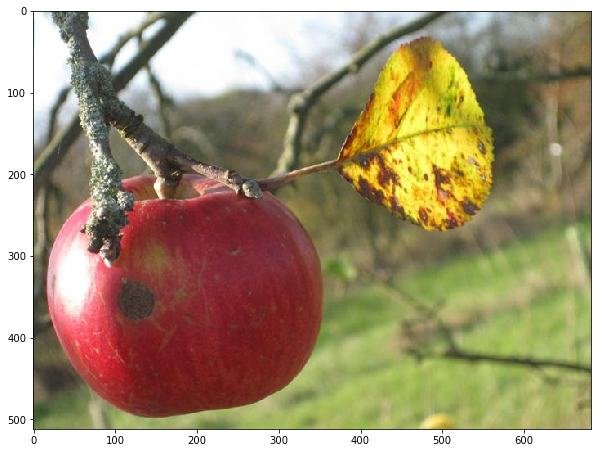

predicted class is: 249
output label: /o/orchard 249
probabilities and labels:


[(0.57777911, '/o/orchard 249'),
 (0.075733252, '/f/field/wild 141'),
 (0.071531065, '/p/pasture 258'),
 (0.050836753, '/b/botanical_garden 62'),
 (0.023499146, '/v/vegetable_garden 345')]

In [49]:
#Path to the models 
net_path = '/home/irvinea/Documents/Scene_class/Scripts/places365/'


#Path to imageset
img_path = '/home/irvinea/Documents/Scene_class/test_large/'

#Load alexnet trained network
net = caffe.Net(net_path + 'deploy_alexnet_places365.prototxt', net_path + 'alexnet_places365.caffemodel', caffe.TEST)
#create transformer for input, which can be used to process images in to standard input for the net 
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
#set the options for transforming the image to neccesary format 
transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

#Load in a random image from the imageset
curr_img = random.choice(os.listdir(img_path))
img = caffe.io.load_image(img_path + curr_img)
#img = caffe.io.load_image(img_path + 'Places365_test_00254259.jpg')
plt.imshow(img)
plt.show()
net.blobs['data'].data[...] = transformer.preprocess('data', img)

### perform classification
output = net.forward()
output_prob = output['prob'][0]  # the output probability vector for the image
print 'predicted class is:', output_prob.argmax()

### compare probabilities to category text 
labels_file = net_path + 'categories_places365.txt'
    
labels = np.loadtxt(labels_file, str, delimiter='\t')
print 'output label:', labels[output_prob.argmax()]

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]  # reverse sort and take five largest items

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

Now we have categorised the scene, let's take a look if any objects exist. Initially we want to know if any specific salient objects exist at all in the image. 

We can do this with a pretrained net designed to tell us how many objects are present in that image. We can use this net called SOS to do this (http://cs-people.bu.edu/jmzhang/sos.html) 

Note: The input images should be zero-centered by mean pixel (rather than mean image) subtraction. Namely, the following BGR values should be subtracted: [104, 117, 123].

In [396]:

#let's do the same but with object classification, using the img file already loaded above: 
obj_net_path = '/home/irvinea/Documents/Scene_class/Scripts/sod/'
obj_net = caffe.Net(obj_net_path + 'deploy.prototxt', obj_net_path + 'GoogleNet_SOS.caffemodel', caffe.TEST)

#set transformer (noting above)
obj_transformer = caffe.io.Transformer({'data': obj_net.blobs['data'].data.shape})
obj_transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR
obj_transformer.set_transpose('data', (2, 0, 1)) # move image channels to outermost dimension
obj_transformer.set_mean('data', np.array([104, 117, 123])) #because above

#process
obj_net.blobs['data'].data[...] = obj_transformer.preprocess('data', img)

### perform classification
obj_output = obj_net.forward()
obj_no = obj_output['prob'][0]
print(obj_no[0])

0.998623


This works kinda OK, but probably not well enough to help us rank things in any meaningful way. We have just an output vector, giving the probabilities of the image contain 1,2,3 or 4+ images. It always seems very sure that there is at least one object in our samples. After playing about I am sure you will see that this is not the kind of thing we are looking for. 

Let's try the classic googlenet recognition Net, which gives us predicted 'synsets' and probabilities: 

In [23]:
g_net_path = '/home/irvinea/Software/caffe/models/bvlc_googlenet/'
g_net = caffe.Net(g_net_path + 'deploy.prototxt', g_net_path + 'bvlc_googlenet.caffemodel', caffe.TEST)

g_transformer = caffe.io.Transformer({'data': g_net.blobs['data'].data.shape})
g_transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR
g_transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
g_transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]

#preprocess and run
g_net.blobs['data'].data[...] = g_transformer.preprocess('data', img)
g_output = g_net.forward()
g_output_prob = g_output['prob'][0]  # the output probability vector for the image

#load labels file 
g_labels_file = '/home/irvinea/Software/caffe/data/ilsvrc12/synset_words.txt'
g_labels = np.loadtxt(g_labels_file, str, delimiter='\t')

# sort top five predictions from softmax output
g_top_inds = g_output_prob.argsort()[::-1][:5]  # reverse sort and take five largest items

print 'probabilities and labels:'
zip(g_output_prob[g_top_inds], g_labels[g_top_inds])

probabilities and labels:


[(0.38697949, 'n06785654 crossword puzzle, crossword'),
 (0.17815398, 'n07565083 menu'),
 (0.074716665, 'n03598930 jigsaw puzzle'),
 (0.032097086, 'n04033901 quill, quill pen'),
 (0.025760414, 'n02971356 carton')]

Let's try using a face detection toolbox. This uses a very simple algorithm: Histogram of Oriented Gradients (HOG). This is not going to be robust to partial or low-res faces, but will give a reliable indication of a full, salient, face. 

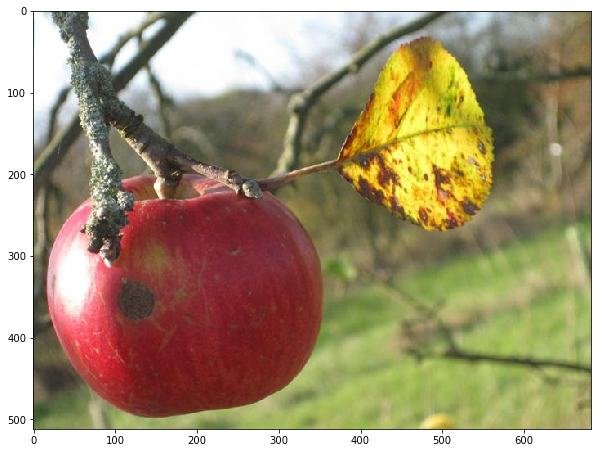

number of detected faces: 0
locations (bounds): []
[]


In [50]:
import face_recognition
image = face_recognition.load_image_file(img_path + curr_img)
face_locations = face_recognition.face_locations(image)
contours = face_locations

for c in contours:
    #c is top, left, bottpom, right, so need to translate
    t, l, b, r = c
    x = r
    y = b
    w = l - r
    h = t - b
    cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)

plt.imshow(image)
plt.show()
print('number of detected faces: ' + str(len(face_locations)))
print('locations (bounds): ' + str(face_locations))

f_spaces = ''.join(i for i in str(face_locations).split(','))
print(f_spaces)

As stated above, this will only work with clear shots of faces. In order to try and converge on detecting people in an image, let's do some pedestrian detection (which will pick out anything that is shaped like a person). For this we can use open CV, which has HOG working with a pre-trained Support Vector Machine (SVM).

((), ())


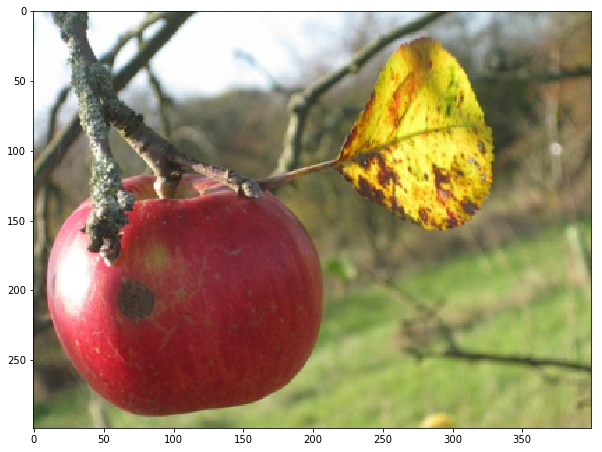

number of people detected: 0
<type 'str'>
()


In [51]:
import imutils
#Tell openCV we are using a HOG
hog = cv2.HOGDescriptor()
#Load Default SVM for detecting people
hog.setSVMDetector( cv2.HOGDescriptor_getDefaultPeopleDetector() )
#Load greyscale image 
h_img =cv2.imread(img_path + curr_img,0)
#resize to improve detection 
h_img= imutils.resize(image, width=min(400, image.shape[1]))
#perform detection, and set parameters for the HOG 
print(hog.detectMultiScale(h_img, winStride=(4,4), padding=(8,8), scale=1.05))
contours, weights = hog.detectMultiScale(h_img, winStride=(4,4), padding=(8,8), scale=1.05)

for c in contours:
    x,y,w,h = c
    cv2.rectangle(h_img,(x,y),(x+w,y+h),(0,0,255),2)
plt.imshow(h_img)
plt.show()
print('number of people detected: '+str(len(weights)))
p_spaces = ''.join(i for i in str(contours).split(','))
p_spaces = str.join("", p_spaces.splitlines())
print(type(p_spaces))
print(p_spaces)

## Complexity analysis 

The next step is to rank these category images by complexity, there is not clear way to measure complexity but there are a few algorithms that can give certain metrics of images. 

The first attempt will be to find the number of corners in an image (pixels where two edges meet), and attempt to rank by number and distribution. This is done using the Shi-Tomasi method, which is implemented in openCV 'goodFeaturesToTrack' function.   

The following was adapted from this tutorial (http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_shi_tomasi/py_shi_tomasi.html)

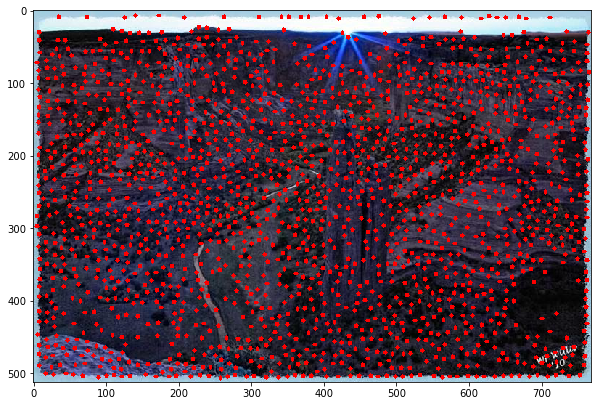

corners: 1812


In [400]:
img = cv2.imread(img_path + curr_img)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

corners = cv2.goodFeaturesToTrack(gray,0,0.01,10)
corners = np.int0(corners)

for i in corners:
    x,y = i.ravel()
    cv2.circle(img,(x,y),3,255,-2)

plt.imshow(img),plt.show()
print('corners: '+ str(len(corners)))

The simplest way to get a rough idea of distribution is to count how many grid squares contain more than a certain value of dots

(600, 600)
717


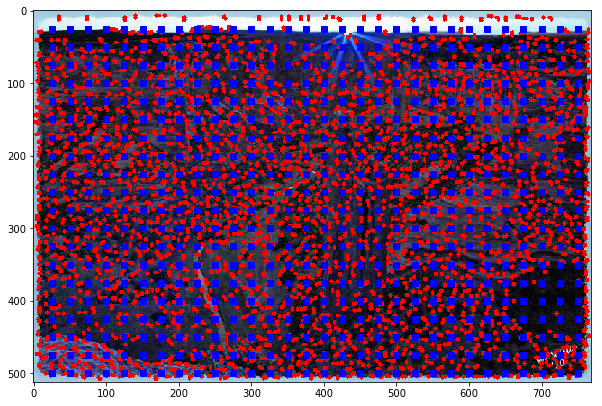

proportion filled:0.965
1681.995


In [401]:
#img = cv2.imread(img_path + random.choice(os.listdir(img_path)))
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

corners = cv2.goodFeaturesToTrack(gray,0,0.01,10)
corners = np.int0(corners)

for i in corners:
    x,y = i.ravel()
    cv2.circle(img,(x,y),3,255,-1)

#unravel the coordinates of X and Y points
x = []
y = []
for i in corners: 
    x.append(i.ravel()[0])
    y.append(i.ravel()[1])

#get image size for creating of grid 
height, width, channels = img.shape
#use the smallest side for squares of grid
squaredim = int(min(width, height)*0.05)

#grid construction
grid_x = [i for i in range(squaredim, width, squaredim) for j in range(squaredim, height, squaredim)]
grid_y = [j for i in range(squaredim, width, squaredim) for j in range(squaredim, height, squaredim)]
print (len(grid_x), len(grid_y))
plt.imshow(img)
plt.plot(grid_x, grid_y, 'bs')
print(x[1])
plt.show()

#loop through each grid point 
grid_all = []
for i in range(len(grid_x)):
    # Get this grid's coordinates
    gridx = grid_x[i]
    gridy = grid_y[i]
    
    #get last grid's coordinates (unless no 1, in which case this will be zero)
    if(i == 1): 
        gridx_last = 0
        gridy_last = 0
    else:
        gridx_last = grid_x[i-1]
        gridy_last = grid_y[i-1]
    #loop through all points.count how many fall within coordinates? 
    grid_cnt = 0
    for ii in range(len(x)):
        if(x[ii] <= gridx and x[ii] >= gridx-squaredim and y[ii] <= gridy and y[ii] >= gridy-squaredim):
            grid_cnt += 1 
        else:
            grid_cnt += 0
    #add this squares number to array 
    grid_all.append(grid_cnt)
    
#percentage of grid squares with corners in them
perc_corners = np.count_nonzero(grid_all)/len(grid_all)
print('proportion filled:' + str(perc_corners))
print(len(corners)*perc_corners)

## Loop through the full image set 
OK, if all seems to be working well we can continue. Now we need to go through the whole set of images and select the ones with a high confidence on the top labels. 

We will also use a couple more nets, to detect objects, people and text. This will be recorded for each image. 

In [ ]:
#get list of all filenames in image directory 
img_list = os.listdir(img_path)

#counter for loop
cnt = 0

print('Number of images in directory: ' + str(len(img_list)))

#name and open output file 
fname = 'output_all.csv'
datafile = open(fname, 'w')

#write headers for CSV 
datafile.write('name, cat1, cat2, cat3, c_prob1, c_prob2, c_prob3, obj1, obj2, obj3, o_prob1, o_prob2, o_prob3, no_face, f_bounds, no_people, p_bounds, corners, coverage, height, width \n')

#loop through all images above 
for imS in img_list:
    
    #load this current image 
    img = caffe.io.load_image(img_path + imS)
    
    #Preprocess the image 
    net.blobs['data'].data[...] = transformer.preprocess('data', img)
    
    #classification
    output = net.forward()
    #labels and probability 
    temp_prob = output['prob'][0]  # the output probability vector for the image
    top_inds = temp_prob.argsort()[::-1][:5] # reverse sort and take top 5 classifications
    
    #store top 5 labels, associated probability and filename of image 
    s_temp_meta = [zip(temp_prob[top_inds], labels[top_inds]), str(imS)]

    # if above 85% probability we can carry on to the next stage
    if (s_temp_meta[0][0][0] >= 0.85):
        
        #pass through object classification
        #preprocess and run
        g_net.blobs['data'].data[...] = g_transformer.preprocess('data', img)
        g_output = g_net.forward()
        g_temp_prob = g_output['prob'][0]
        g_top_inds = g_temp_prob.argsort()[::-1][:5] # reverse sort and take top 5 classifications
        g_temp_meta = [zip(temp_prob[top_inds], labels[top_inds]), str(imS)]
        
        #pass through HOG-SVM face detection 
        image = face_recognition.load_image_file(img_path+str(imS))
        face_locations = face_recognition.face_locations(image)
        no_face = len(face_locations)
        f_coords = face_locations 
        f_spaces = ''.join(i for i in str(f_coords).split(','))
        
        #pass through HOG-SVM person detection 
        hog = cv2.HOGDescriptor()
        #Load Default SVM for detecting people
        hog.setSVMDetector( cv2.HOGDescriptor_getDefaultPeopleDetector() )
        #Load greyscale image 
        h_img =cv2.imread(img_path+str(imS),0)
        #resize to improve detection 
        h_img= imutils.resize(image, width=min(400, image.shape[1]))
        #perform detection, and set parameters for the HOG 
        p_coords, weights = hog.detectMultiScale(h_img, winStride=(4,4), padding=(8,8), scale=1.05)
        # turn coordinates to string with no commas (forCSV so it doesn't misinterpret anything)
        p_spaces = ''.join(i for i in str(p_coords).split(','))
        # remove new lines 
        p_spaces = str.join("", p_spaces.splitlines())
        no_p = len(p_coords)
        
        #Corner detection
        img = cv2.imread(img_path+str(imS))
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        corners = cv2.goodFeaturesToTrack(gray,0,0.01,10)
        corners = np.int0(corners)
        
        #corner density: A LOT OF CODE 
        for i in corners:
            x,y = i.ravel()
            cv2.circle(img,(x,y),3,255,-1)

        #unravel the coordinates of X and Y points
        x = []
        y = []
        for i in corners: 
            x.append(i.ravel()[0])
            y.append(i.ravel()[1])

        #get image size for creating of grid 
        height, width, channels = img.shape
        #use the smallest side for squares of grid
        squaredim = int(min(width, height)*0.05)

        #grid construction
        grid_x = [i for i in range(squaredim, width, squaredim) for j in range(squaredim, height, squaredim)]
        grid_y = [j for i in range(squaredim, width, squaredim) for j in range(squaredim, height, squaredim)]
        
        grid_all = []
        for i in range(len(grid_x)):
            # Get this grid's coordinates
            gridx = grid_x[i]
            gridy = grid_y[i]

            #get last grid's coordinates (unless no 1, in which case this will be zero)
            if(i == 1): 
                gridx_last = 0
                gridy_last = 0
            else:
                gridx_last = grid_x[i-1]
                gridy_last = grid_y[i-1]
            #loop through all points.count how many fall within coordinates? 
            grid_cnt = 0
            for ii in range(len(x)):
                if(x[ii] <= gridx and x[ii] >= gridx-squaredim and y[ii] <= gridy and y[ii] >= gridy-squaredim):
                    grid_cnt += 1 
                else:
                    grid_cnt += 0
            #add this squares number to array 
            grid_all.append(grid_cnt)

        #percentage of grid squares with corners in them
        perc_corners = np.count_nonzero(grid_all)/len(grid_all)

        #JPEG Size and Dimensions 
        #height and width defined above 
        
        #output_prob.append([zip(temp_prob[top_inds], labels[top_inds]), str(i)])

        #Write all information to CSV file: 
        #                                                                                 ('name,           cat1,               cat2,                 cat3,                 c_prob1,              c_prob2,              c_prob3,              obj1,                 obj2,                 obj3,                 o_prob1,              o_prob2,              o_prob3,              no_face, f_bounds, no_people, p_bounds, corners, coverage, height, width \n')
        datafile.write('{},{},{},{},{},{},{},{},{},{},{},{},{},{},{},{},{},{},{},{},{} \n'.format(str(imS), s_temp_meta[0][0][1], s_temp_meta[0][1][1], s_temp_meta[0][2][1], s_temp_meta[0][0][0], s_temp_meta[0][1][0], s_temp_meta[0][2][0], g_temp_meta[0][0][1], g_temp_meta[0][1][1], g_temp_meta[0][2][1], g_temp_meta[0][0][0], g_temp_meta[0][1][0], g_temp_meta[0][2][0], no_face, f_spaces, no_p, p_spaces, len(corners), perc_corners, height, width))

    #Counter which outputs percentage done 
    cnt += 1
    x = (cnt/len(img_list))*100
    sys.stdout.write("\r%s" % str(x) + '% done')
    sys.stdout.flush()

#Close CSV 
datafile.close()

Number of images in directory: 328500
13.4322678843% doneeeee

In [41]:
datafile.close()


Depending on set up, the above step may take a long time. 

Now this is done, we can look at the number of unique labels in this sample that have been identified:

In [15]:

top_labels = [item[0][0][1] for item in selected]
u = np.unique(top_labels)
print('All entries: '+ str(len(top_labels)))
print 'unique labels: ' + str(len(u)) 



NameError: name 'selected' is not defined

In [ ]:
(°


<AsyncMapResult: de>